# Plot

## Result 1: Describtion of questionnaire data

In [1]:
# Import datasets
from data_process import *

# Import external libraries
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
mpl.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in'

### Fig A: comparing actual pop distribution and survey distribution.

Text(0, 0.5, 'Proportion')

Text(0.5, 0, 'Location code')

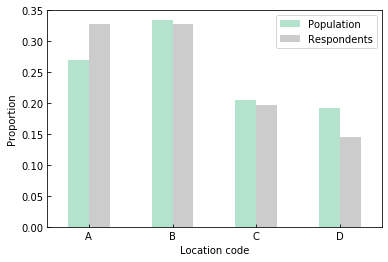

In [2]:
# Processing the distribution of actual population.
k = 1 - 0.2436
city_rate = 0.55
pop['location_code'] = pop['location'].str[0]
for index in range(len(pop)):
    if pop.loc[index, "location"] == "A":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] / 3
    elif pop.loc[index, "location"][0] == "B":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] * k
    elif pop.loc[index, "location"] in ["C1", "C2"]:
        pop.loc[index, "use_pop"] = pop.loc[index, "city"]
    elif pop.loc[index, "location"] == "C3":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] * k 
    elif pop.loc[index, "location"][0] == "D":
        pop.loc[index, "use_pop"] = pop.loc[index, "population"] * city_rate
        
pop_distribution = pop.groupby("location_code")['use_pop'].mean().astype(int)
pop_distribution = pop_distribution / pop_distribution.sum()

sample_distribution = questionnaires['location_code'].value_counts() / len(questionnaires)
distribution = pd.DataFrame({
    'location': pop_distribution.index,
    'Population': pop_distribution.values,
    'Respondents': sample_distribution.values
})

fig, ax1 = plt.subplots()
distribution.plot(kind='bar', x='location', rot=0, ax=ax1, colormap='Pastel2')
ax1.set_ylabel("Proportion")
ax1.set_xlabel("Location code")

### Fig B：Catalogues of respondents

In [3]:
gender_ratio = questionnaires['men'].sum() / questionnaires['women'].sum()
gender_ratio_census = 2789 / 2672  # data from http://data.stats.gov.cn
print("gender ratio of our survey is {:.2f}, while in census data {:.2f}".format(gender_ratio, gender_ratio_census))

farm_ratio = questionnaires['farm'].sum() / len(questionnaires)
farm_ratio_census = 283 / 688
print("farm proportion of our survey is {:.2%}, while in census data {:.2%}".format(farm_ratio, farm_ratio_census))

gender ratio of our survey is 1.00, while in census data 1.04
farm proportion of our survey is 43.23%, while in census data 41.13%


In [4]:
memory_map = {
    'heard of somewhere': 'Heard of',
    'heard from intimates': 'Heard of',
    'know from written records': 'Read about',
    'experienced': 'Experienced'
}

questionnaires_2 = questionnaires.replace(memory_map, inplace=False, regex=True)

catalogue_farm = ['rural', 'urban'] 
catalogue_memory = ["Heard of", "Read about", "Experienced"] 
catalogue_education = list(questionnaires_2['education'].dropna().unique())
catalogues = catalogue_farm + catalogue_memory + catalogue_education

links = []
colors = {'farm': '#FF5722', 'off-farm': '#FFC107'}
numbers = {'farm': len(questionnaires_2[questionnaires_2['farm']]),
          'off-farm': len(questionnaires_2) - len(questionnaires_2[questionnaires_2['farm']])}

numbers

def add_farm_to_memory_sankey(data, source, links):
    n = 0
    answers = []
    for year in MAJOR_HISTORICAL_FLOODS:
        answers += list(data[str(year)].values)
    answer_dict = {}
    for answer in answers:
        tmp_list = answer.split("; ")
        for item in tmp_list:
            if item in catalogue_memory:
                n += 1
                if item in answer_dict:
                    answer_dict[item] += 1
                else:
                    answer_dict[item] = 1           
    for how_get_known, value in answer_dict.items():
        links.append({
            'source': source,
            'target': how_get_known,
            'value': value / n,
            'type': source,
            'color': colors[source]
        }) 
    return links


farm_data = questionnaires_2[questionnaires_2['farm']]
links = add_farm_to_memory_sankey(farm_data, 'farm', links)
off_farm_data = questionnaires_2[questionnaires_2['farm'] == False]
links = add_farm_to_memory_sankey(off_farm_data, 'off-farm', links)

farm_to_education = questionnaires_2.pivot_table(index=['farm', 'education'], values='valid', aggfunc=np.count_nonzero)
for source, value in farm_to_education.loc[True]['valid'].items():
    links.append({
        'source': source,
        'target': 'farm',
        'value': value / numbers['farm'],
        'type': 'farm',
        'color': colors['farm']
    })

    
off_farm_to_education = questionnaires_2.pivot_table(index=['farm', 'education'], values='valid', aggfunc=np.count_nonzero)
for source, value in farm_to_education.loc[False]['valid'].items():
    links.append({
        'source': source,
        'target': 'off-farm',
        'value': value / numbers['off-farm'],
        'type': 'off-farm',
        'color': colors['off-farm']
    })

links2 = []
for i in range(len(links)):
    links2.append({})
    for a, b in links[i].items():
        links2[i][a] = b
        if type(b) is str:
            replaced = b.replace('off-farm', 'Urban')
            replaced = replaced.replace('farm', 'Rural')
            links2[i][a] = replaced
            
pd.DataFrame(links2)

{'farm': 262, 'off-farm': 344}

,source,target,value,type,color
0,Rural,Heard of,0.660777,Rural,#FF5722
1,Rural,Read about,0.210247,Rural,#FF5722
2,Rural,Experienced,0.128975,Rural,#FF5722
3,Urban,Read about,0.371342,Urban,#FFC107
4,Urban,Heard of,0.608476,Urban,#FFC107
5,Urban,Experienced,0.020182,Urban,#FFC107
6,Basic,Rural,0.515267,Rural,#FF5722
7,Higher,Rural,0.465649,Rural,#FF5722
8,Uneducated,Rural,0.019084,Rural,#FF5722
9,Basic,Urban,0.145349,Urban,#FFC107


In [5]:
from pyecharts.charts import Sankey
from pyecharts import options as opts
nodes = [{'name': name} for name in catalogues]
pic = (
    Sankey()
    .add('',
         nodes,
         links2,
         linestyle_opt=opts.LineStyleOpts(opacity = 0.3, curve = 0.5, color = "source"),
         label_opts=opts.LabelOpts(position="top"),
         node_gap = 30,
         orient="vertical",      #更改的是这里
    )
    .set_global_opts(title_opts=opts.TitleOpts(title = '调查结果'))
)

pic.render('images/sankey_test.png')
nodes

'C:\\Users\\ssgg9240\\Dropbox\\Pycharm projects\\Collective-Memory\\images\\sankey_test.png'

[{'name': 'rural'},
 {'name': 'urban'},
 {'name': 'Heard of'},
 {'name': 'Read about'},
 {'name': 'Experienced'},
 {'name': 'Higher'},
 {'name': 'Basic'},
 {'name': 'Uneducated'}]

### Fig C: Memory of major flooding

Text(0.5, 0, 'Major historical ﬂoods')

Text(0, 0.5, 'Number of respondents')

(0.6941187238797208, 0.19348956757423041)

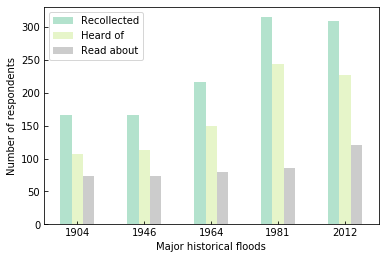

In [6]:
major_floods = water_level.loc[MAJOR_HISTORICAL_FLOODS]
fre = stats_fre_questionnaris(questionnaires, MAJOR_HISTORICAL_FLOODS, normalize=False)
fre['Recollected'], fre['Heard of'], fre['Read about'] = fre['collective'], fre['communicative'], fre['cultural']
fig, ax2 = plt.subplots()
fre[['Recollected', 'Heard of', 'Read about']].plot(kind='bar', ax=ax2, rot=0, colormap='Pastel2')
ax2.set_xlabel("Major historical ﬂoods")
ax2.set_ylabel("Number of respondents")

from scipy.stats import pearsonr
pearsonr(fre['Heard of'].values, fre['Read about'].values)

### Fig D: Relative collective memory

Text(0.5, 0, 'Major historical floods')

Text(0, 0.5, 'Recollection scaled by relative flooding level')

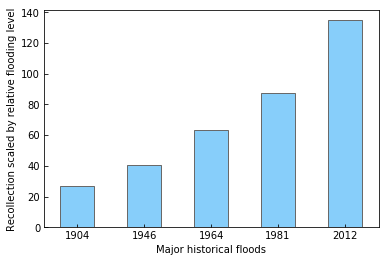

In [7]:
ratio = (major_floods['flood_level'] - W_MIN)
scaled = fre['collective'] / ratio


fig, ax3 = plt.subplots()
scaled.plot(kind='bar', rot=0, ax=ax3, color='lightskyblue', edgecolor='dimgrey')
ax3.set_xlabel("Major historical floods")
ax3.set_ylabel("Recollection scaled by relative flooding level")

### Fig E: Scores

Text(0.5, 0, 'Scores')

,levee,report,maner
count,606.000000,606.000000,606.000000
mean,7.318482,7.363036,7.521452
std,1.902383,1.859589,1.907454
min,1.000000,1.000000,1.000000
25%,6.000000,6.000000,6.000000
50%,7.000000,7.000000,8.000000
75%,9.000000,9.000000,9.000000
max,10.000000,10.000000,10.000000


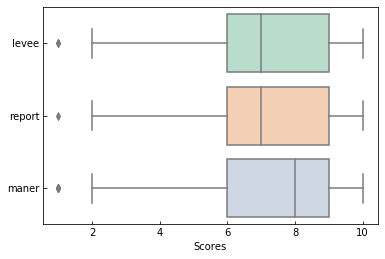

In [8]:
fig, ax6 = plt.subplots()
sns.boxplot(data=questionnaires[['levee', 'report', 'maner']], orient='h', ax=ax6, palette='Pastel2')
ax6.set_xlabel("Scores")
questionnaires[['levee', 'report', 'maner']].describe()
plt.show()

D:\anaconda3.5\lib\site-packages\ipykernel_launcher.py:101: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


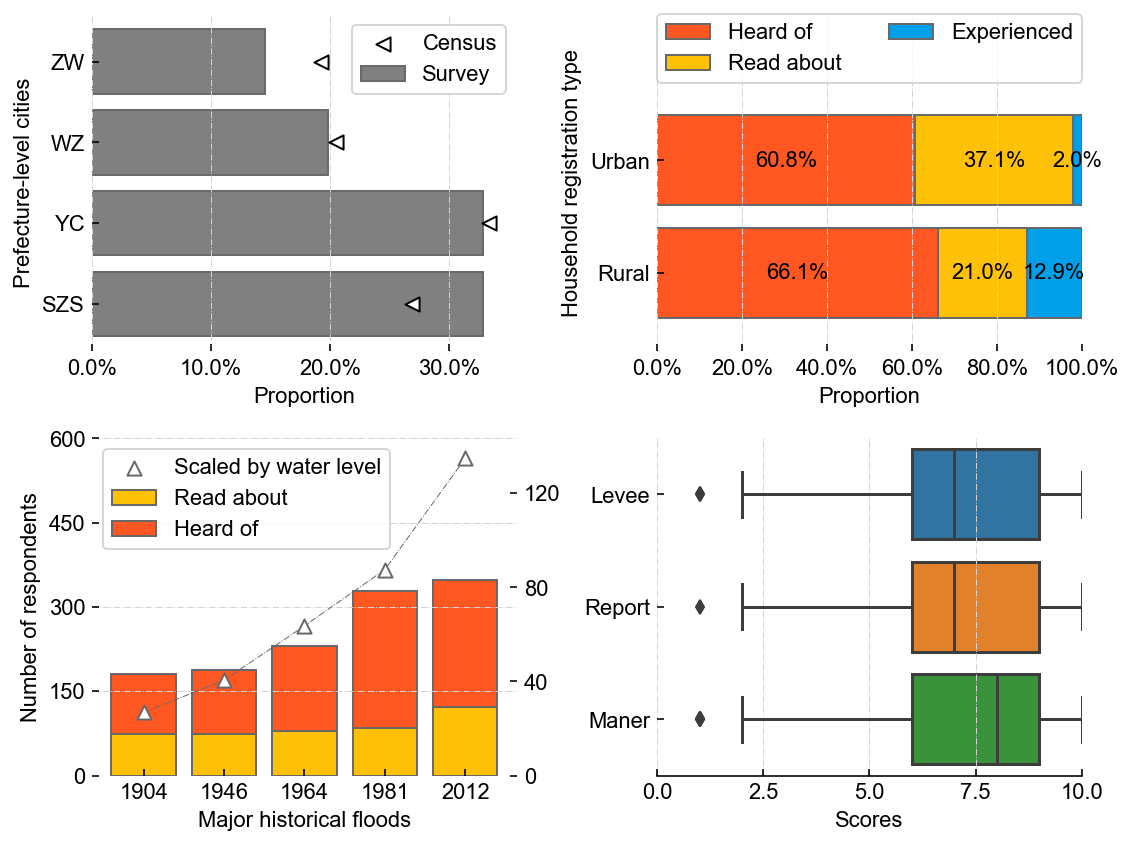

In [10]:
%config InlineBackend.figure_format ='retina'  # 输出高清大图
fig, ((ax1,ax2),(ax4,ax6)) = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)

# fig A:
from matplotlib.ticker import FuncFormatter
# 修改字体字号
mpl.rcParams['font.family'] = ['Arial']
mpl.rcParams.update({'font.size': 11})


def to_percent(temp, position):
    return '%.1f'%(100 * temp) + '%'

ax1.barh(y=distribution['location'], width=distribution['Respondents'], color='gray', edgecolor='dimgrey', zorder=1, label='Survey')
ax1.scatter(y=distribution['location'], x=distribution['Population'], marker='<', s=50, color='w', edgecolors='black', zorder=2, label='Census')

# distribution.plot(kind='barh', x='location', rot=0, ax=ax1, colormap='Set2')
ax1.set_xlabel("Proportion")
ax1.set_ylabel("Prefecture-level cities")
ax1.set_yticklabels(['SZS', 'YC', 'WZ', 'ZW'])
ax1.xaxis.set_major_formatter(FuncFormatter(to_percent))
ax1.legend()


# Fig B:
df = pd.DataFrame(links2)
def bar_plot(data, loc, ax, add_label=True):
    right = 0
    colors = ['#FF5722', '#FFC107', '#00A0E8']  # read, heard, experienced
    labels = ['Heard of', 'Read about', 'Experienced']
    for i in range(len(data)):
        value = data['value'].iloc[i]
        left = right
        right = right + value
        text = "{:.1%}".format(data['value'].iloc[i])
        color = colors[i]
        label = labels[i]
        ax.text((left+right)/2, loc, text, ha='center', va='center')
        if add_label:
            ax.barh(y=loc, left=left, width=value, color=color, edgecolor='dimgrey', zorder=0, label=label)
        else:
            ax.barh(y=loc, left=left, width=value, color=color, edgecolor='dimgrey', zorder=0)


data1 = df[df['source']=='Rural'].sort_values(by='value', ascending=False)
bar_plot(data1, 1, ax2)
data2 = df[df['source']=='Urban'].sort_values(by='value', ascending=False)
bar_plot(data2, 2, ax2, add_label=False)

ax2.set_yticks([1, 2])
ax2.set_ylim(0.3, 3.3)
ax2.set_yticklabels(['Rural', 'Urban'])
ax2.xaxis.set_major_formatter(FuncFormatter(to_percent))
ax2.set_xlim(0, 1)
ax2.set_ylabel('Household registration type')
ax2.set_xlabel('Proportion')
ax2.legend(loc=9, ncol=2, mode="expand", borderaxespad=0.)


# Fig C:
n = len(questionnaires)
ax4.bar(x=fre.index.astype(str), height=fre['Read about'], color='#FFC107', edgecolor='dimgrey', label='Read about')
ax4.bar(x=fre.index.astype(str), bottom=fre['Read about'], height=fre['Heard of'], color='#FF5722', edgecolor='dimgrey', label='Heard of')
ax4.scatter(x=scaled.index.astype(str), y=scaled, color='w', marker='^', 
            label='Scaled by water level', s=50, edgecolor='dimgrey', zorder=-1)

ax5 = ax4.twinx()
ax5.plot(scaled.index.astype(str), scaled, "-.", color='dimgrey', lw=0.5, zorder=1)
ax5.scatter(x=scaled.index.astype(str), y=scaled, color='w', marker='^', 
            label='Scaled by water level', s=50, edgecolor='dimgrey', zorder=2)
ax4.set_xlabel("Major historical ﬂoods")
ax4.set_ylabel("Number of respondents")
ax4.legend(loc=2)


# fig E
sns.boxplot(data=questionnaires[['levee', 'report', 'maner']], 
            orient='h', ax=ax6, palette='tab10')
ax6.set_yticklabels([s.capitalize() for s in ['levee', 'report', 'maner']])
ax6.set_xlabel("Scores")
ax6.set_xlim(0, 10)


# beautification
for ax in [ax1, ax2, ax4, ax5, ax6]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
for ax in [ax4]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.grid(color='lightgray', linestyle='-.', linewidth=0.5, zorder=10)
for ax in [ax1, ax2, ax6]:
    ax.xaxis.grid(color='lightgray', linestyle='-.', linewidth=0.5, zorder=10)

ax4.set_yticks(np.arange(0, n, 150))
ax5.set_yticks(np.arange(0, 160, 40))
ax6.spines['bottom'].set_visible(True)
ax6.set_xticks(np.arange(0, 10.1, 2.5))

plt.savefig('images/result1.jpg', format='jpg', dpi=300)
plt.show();